[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Buddha-subedi/PMWPrecip_TLP-R2S/blob/main/TLP-R2S_demo.ipynb)

# <center> <font color='blue'> **An Incremental Learning Framework Linking Reanalysis and Radar Data for Passive Microwave Precipitation Retrievals** <center>

#### <center> <font color='balck'> Buddha Subedi, Mahyar Garshasbi, Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering,
#### <center> University of Minnesota <center>
#### <center> Date: May, 2025 (rev 01)

---
<p align="justify"> This notebook representes the results of an algorithm, called the Boosted Transfer Learning of global Precipitation from Reanalysis data to Satellite observations (TLP-R2S), a novel machine learning framework based on an ensemble of extreme gradient-boosted decision trees that accommodates heterogeneous training data, with emphasis on using Cloud Profiling Radar (CPR) data for training. The algorithm is incrementally trained by combining pre-training on reanalysis precipitation with post-training on coincident Dual-frequency Precipitation Radar (DPR) rainfall and CPR snowfall observations to cope with satellite data sparsity. Applied to PMW retrievals from the Global Precipitation Measurement (GPM) Microwave Imager (GMI) and the Special Sensor Microwave Imager/Sounder (SSMIS), the proposed approach transfers prior information from reanalysis to posterior constraints from radar observations and employs a sequential detection–estimation strategy for precipitation phase and rate. The method substantially improves high-latitude snowfall retrievals, mitigating systematic biases in current GPM products, including Arctic overestimation and Antarctic underestimation. Validation against independent Multi-Radar Multi-Sensor (MRMS) data demonstrates enhanced precipitation phase detection and rate estimation relative to reanalysis-based retrievals and individual spaceborne radar observations, provided sufficient coincident radar data are available for training.

This notebook is organized as follows. Section 1, describes the data including the GPM and CloudSat products as well as the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). Section 2 describes the methodolgy for training the networks, and the last section provides an example for precipitation orbital retrieval using the proposed algorithm.

# **1. Data**

**1.1** **Data Description**

<span style="color:green;"><b><i>1.1.1 Satellite and Reanalysis Input Data</i></b></span>

Brightness temperatures (TBs) from the SSMIS and GMI radiometers are used in this study as inputs to TLP-R2S, with separate models trained for each sensor. Furthermore, a set of hourly [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) reanalysis products -- available at spatial resolution of 31km is used as ancillary input features to implicitly learn the relationships between land-atmosphere dynamical and thermodynamic state variables and their emissivity.


***SSMIS TBs***
*   Eleven frequency channels from 19 to 183 GHz, available in the GPM V07 data suite


***GMI TBs***
*   Thirteen frequency channels from 10 to 183 GHz

***Atmospheric Variables***
*   tclw = Total Column Cloud Liquid Water ($\rm kg/m^2$)
*   tciw = Total Column Cloud Ice Water ($\rm kg/m^2$)
*   tcwv = Total Column Water Vapor ($\rm kg/m^2$)
*   cape = Convective Available Potential Energy ($\rm j/kg$)
*   t2m = 2m air temperature ($\rm K$)
*   u10 = 10m u-component of wind ($\rm m/s$)
*   v10 = 10m v-component of wind ($\rm m/s$)
*   tcslw = Total Column Supercooled Liquid Water ($\rm \frac{kg}{m^2}$)
*   tcw = Total Column Water ($\rm \frac{kg}{m^3}$)


***Surface Type Variables***
*   lsm = LandSeaMask
*   siconc = Sea Ice Area Fraction
*   sd = Snow Depth ($\rm m$)
*   swvl1 = Volumetric Soil Water Layer1 (-)

<span style="color:green;"><b><i>1.1.2 Output Labels and Rates</i></b></span>

The ERA5 precipitation is used as a pre-training output feature. After pre-training, the model is post-trained on radar observations, with DPR providing the output rainfall labels and rates, while snowfall labels and rates are obtained from the CPR.

More specifically, the near-surface rainfall data are from the 2A-DPR product, based on blind zone extrapolations. The CPR near-surface snowfall is from 2C-PRECIP-COLUMN and the 2C-SNOW-PROFILE, which provide precipitation phase and snowfall rate, respectively.

Figure 1, represents the way the coincidences between GMI and CloudSat profiling radar (CPR) and GMI and DPR are collected. For more details with respect to the CloudSat and GMI please refer to ([2](https://journals.ametsoc.org/view/journals/hydr/22/7/JHM-D-20-0296.1.xml))

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_TLP-R2S/blob/main/images/coincidence_image.png?raw=1" alt="Coincidence Image" width="800"/><br/>
  <em><strong>Figure 1.</strong> Schematic of a CloudSat-GPM coincidence segment (left), and DPR-GMI coincidence (right).</em>
</div>

To minimize redundancy and ambiguity arising from resolution mismatches between datasets, all retrievals are conducted at the native footprints of the SSMIS-S4 (GMI-S2) channels, with approximately 12.5$\times$12.9 (5.1$\times$13.2) km resolution. After harmonization, the analyzed ERA5-labeled SSMIS (GMI) data include approximately 10.4E+6 (7E+6) data points, of which 2.5E+6 (2.5E+6) are labeled as raining and 1.9E+6 (1E+6) as snowing. The CPR and DPR coincidence samples with SSMIS (GMI) after harmonization consist of 4.3E+6 (2.4E+5) and 40.6E+6 (2.9E+9) data points, respectively. The class imbalance ratio is adjusted to maintain the proportions of 3.2--1.3--1 (3.5--2.5--1) for clear--rain--snow, based on a climatological analysis of global ERA5 data.

> **Note:** The demo code implementation below is for the **GMI sensor** and is demonstrated on **partial datasets only**. The example is intended solely to illustrate the methodology and does not represent results from the complete database.


## **1.2 Database Organization and Loading**

**Inputs for the phase detection and rate estimation are as follows:**
> **Inputs:**

*   $\text{TBs} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $ \text{tciw} = X_{train}(:,14)$ (Cloud Liquid Water Path)
*   $\text{tclw} = X_{train}(:,15)$ (Cloud Ice Water Path)
*   $\text{tcwv} = X_{train}(:,16)$ (2-meter Air Temperature)
*   $\text{t2m} = X_{train}(:,17)$ (Water Vapor Path)
*   $\text{cape} = X_{train}(:,18)$ (Convective Potential Energy)

*   $\text{u10} = X_{train}(:,19)$ (10m u-component of wind)
*   $ \text{v10} = X_{train}(:,20)$ (10m v-component of wind)
*   $\text{skt} = X_{train}(:,21)$ (Skin Temperature)


*   $\text{sd} = X_{train}(:,22)$ (Snow Depth)
*   $ \text{tcslw} = X_{train}(:,23)$ (Total Column Supercooled Liquid Water)
*   $\text{tcw} = X_{train}(:,24)$ (Total Column Water)
*   $\text{swvl1} = X_{train}(:,25)$ (Volumetric Soil Water Layer1)
*   $\text{lsm} = X_{train}(:,26)$ (LandSeaMask)
*   $\text{siconc} = X_{train}(:,27)$ (Sea Ice Area Fraction)




> **Outputs:**

*   Output of the phase network is a vector containing either of the three integer values **0 (no precipitation)**, **1 (rainfall)**, and **2 (snowfall)**

**For the precipitation estimation, the inputs and outputs are as follows:**

> **Inputs:**

*    The same set of input features that was used for classification is used here as well

> **Outputs**:

*   Output of the estimation network is a vector containing rainfall/snowfall rate [$\rm mm.hr^{-1}$].

## **1.3 Code**
To run this notebook on Google Colab, you need to clone this repository

In [6]:
# Clone the repo
import os
!git clone https://github.com/Buddha-subedi/PMWPrecip_TLP-R2S.git
os.chdir("PMWPrecip_TLP-R2S")

Cloning into 'PMWPrecip_TLP-R2S'...
remote: Enumerating objects: 521, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 521 (delta 131), reused 63 (delta 63), pack-reused 338 (from 1)
Receiving objects: 100% (521/521), 121.88 MiB | 19.41 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Updating files: 100% (26/26), done.


In [ ]:
!pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.2
    Uninstalling xgboost-3.1.2:
      Successfully uninstalled xgboost-3.1.2


In [ ]:
# Import Necessary Packages
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from pathlib import Path
import xgboost as xgb
import os
import scipy.io
import pmw_utils
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error
import scipy.stats as stats
from scipy.interpolate import interp1d
importlib.reload(pmw_utils)
from pmw_utils import plot_confusion_matrix, TLPR2S_model

In [ ]:
paths_phase = {
    'cpr_train': 'data/df_cpr_phase_train.npz',
    'cpr_test':  'data/df_cpr_phase_test.npz',
    'dpr_train': 'data/df_dpr_phase_train.npz',
    'dpr_test':  'data/df_dpr_phase_test.npz',
    'era5_train': 'data/df_era5_phase_train.npz',
    'era5_test':  'data/df_era5_phase_test.npz'
}
data = {k: np.load(p) for k, p in paths_phase.items()}
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}
df_cpr_phase_train = dfs['cpr_train']
df_cpr_phase_test  = dfs['cpr_test']
df_dpr_phase_train = dfs['dpr_train']
df_dpr_phase_test  = dfs['dpr_test']
df_era5_phase_train = dfs['era5_train']
df_era5_phase_test  = dfs['era5_test']

In [ ]:
paths_rate = {
    'cpr_snow_rate_train': 'data/df_csat_snow_rate_train.npz',
    'cpr_snow_rate_test':  'data/df_csat_snow_rate_test.npz',
    'dpr_rain_rate_train': 'data/df_dpr_rain_rate_train.npz',
    'dpr_rain_rate_test':  'data/df_dpr_rain_rate_test.npz',
    'era5_snow_rate_train': 'data/df_era5_snow_rate_train.npz',
    'era5_snow_rate_test':  'data/df_era5_snow_rate_test.npz',
    'era5_rain_rate_train': 'data/df_era5_rain_rate_train.npz',
    'era5_rain_rate_test':  'data/df_era5_rain_rate_test.npz'
}

# Load .npz files
data = {k: np.load(p) for k, p in paths_rate.items()}

# Convert to DataFrames
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}

# Assign to variables
df_cpr_snow_rate_train = dfs['cpr_snow_rate_train']
df_cpr_snow_rate_test  = dfs['cpr_snow_rate_test']
df_dpr_rain_rate_train = dfs['dpr_rain_rate_train']
df_dpr_rain_rate_test  = dfs['dpr_rain_rate_test']
df_era5_snow_rate_train = dfs['era5_snow_rate_train']
df_era5_snow_rate_test  = dfs['era5_snow_rate_test']
df_era5_rain_rate_train = dfs['era5_rain_rate_train']
df_era5_rain_rate_test  = dfs['era5_rain_rate_test']

In [ ]:
paths_cdf = {
    'cdf_rain': 'data/df_cdf_rain.npz',
    'cdf_snow':  'data/df_cdf_snow.npz'
}
data = {k: np.load(p) for k, p in paths_cdf.items()}
dfs = {k: pd.DataFrame(dict(v)) for k, v in data.items()}
df_cdf_rain = dfs['cdf_rain']
df_cdf_snow  = dfs['cdf_snow']

# **2.  Methodology**
The TLP-R2S is a two-step precipitation retrieval algorithm, in which the precipitation flag (i.e., clear-sky, rain, and snow) is first determined, followed by the rate estimation. The algorithm comprises three base learners: one for phase classification and two for rainfall and snowfall rate estimations. Each base learner operates in two stages to enable incremental learning and information transfer from pre-training (Stage I) to post-training (Stage II). In Stage I, the model is trained and optimized on ERA5 precipitation labels or rates, with hyperparameters tuned to achieve optimal performance. In Stage II, the architecture of the pre-trained model (e.g., tree depth, number of boosters, splitting conditions) is frozen, and additional boosters are trained to learn fine-scale radar precipitation until a stopping criterion is met.

<div align="center">
  <img src="https://github.com/Buddha-subedi/Microwave_Precipitation_Retrievals_from_TLP-R2S/blob/main/images/Fig_01.png?raw=1" alt="B-RAINS Architecture" width="700"/><br/>
  <em>
    <strong>Figure 2.</strong> The TLP-R2S architecture employs incremental training of an ensemble of gradient-boosted decision trees to transfer knowledge from ERA5 simulations to spaceborne radar observations. It is a two-step framework: Step 1 performs classification, and Step 2 applies a regression learner depending upon the detected phase. Each step comprises two stages. In Stage I, a finite number of base trees is sequentially boosted to capture prior relationships between input variables and ERA5 precipitation phase and rate. In Stage II, with a frozen pre-trained model, additional boosting rounds are appended to learn posterior relationships between TBs and active radar observations from DPR and CPR, thereby refining phase and rate estimates.
  </em>
</div>

Figure 3 (first row) illustrates the effect of incremental learning on the GMI retrieval of a rainstorm that occurred along the tropical cyclone track over the southern Indian Ocean. The left panel shows the $T_B$ at 37 GHz, highlighting emission patterns that delineate organized convective frontal cells followed by stratiform trailing cloud decks. The TLP-R2S retrievals, trained solely on ERA5 samples (panel c), with $n_e = 90$ boosting rounds, produce a relatively smooth rainfall field similar to the ERA5 reference (panel b) that lacks the fine-scale convective features evident in the observed TB field. When additional $n_s$ boosting rounds are introduced after freezing to incorporate the information content of satellite observations (panels~c--e), the retrievals exhibit enhanced spatial detail and higher intensity values, effectively capturing the convective organization of the storm.

Figure 3 (second row) presents an example of snowstorm retrievals using SSMIS observations over the region south of Cape Agulhas and the Greenland Sea. Compared with the rainfall case, the improvement in spatial detail is modest; however, mild sharpening remains evident. Notably, a portion of the storm in the southeast part of the scene, with a band scattering signatures at 150 GHz, is retrieved, whereas ERA5 does not predict any surface snowfall.

<div align="center">
  <img src="https://i.postimg.cc/dt6YcXmP/Fig-03.png" alt="Impact of Transfer Learning" width="800"/><br/>
  <em>
    <strong>Figure 3.</strong> The impact of incremental learning on retrievals of a rain storm (a-e) captured by GMI orbit 027551 on January 3, 2019; and a snow storm (f-j) observed by SSMIS orbit 099097 on January 1, 2023 -- where n_e and n_s are boosting rounds before and after freezing, respectively.
  </em>
</div>

## **2.1  Training TLP-R2S**

### **2.1.1  classification**

Stage 1: Learning ERA5 labels

[0]	train-merror:0.10311	test-merror:0.16921
[1]	train-merror:0.09048	test-merror:0.16471
[2]	train-merror:0.08307	test-merror:0.16321
[3]	train-merror:0.07581	test-merror:0.16029
[4]	train-merror:0.07003	test-merror:0.16021
[5]	train-merror:0.06482	test-merror:0.15950
[6]	train-merror:0.06080	test-merror:0.15921
[7]	train-merror:0.05545	test-merror:0.15836
[8]	train-merror:0.05241	test-merror:0.15807
[9]	train-merror:0.04820	test-merror:0.15679
[10]	train-merror:0.04631	test-merror:0.15686
[11]	train-merror:0.04409	test-merror:0.15643
[12]	train-merror:0.04073	test-merror:0.15600
[13]	train-merror:0.03870	test-merror:0.15607
[14]	train-merror:0.03664	test-merror:0.15486
[15]	train-merror:0.03401	test-merror:0.15329
[16]	train-merror:0.03171	test-merror:0.15250
[17]	train-merror:0.02999	test-merror:0.15321
[18]	train-merror:0.02741	test-merror:0.15364
[19]	train-merror:0.02520	test-merror:0.15421
[20]	train-merror:0.02299	test-merror:0.15400
[21]	train-merror:0.02158	test-merror:0.1542

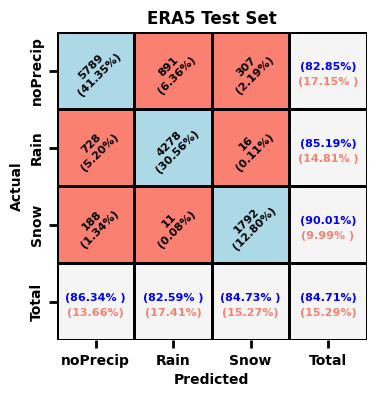

In [ ]:
input_vars = ['10v', '10h', '18v', '18h','23v','36v', '36h', '89v', '89h', '166v', '166h','183-3', '183-7',
              'tciw','tclw','tcwv','t2m','cape','u10', 'v10', 'skt',
              'sd', 'tcslw','tcw','swvl1','lsm', 'siconc']

# Train/test split
x_train_era5 = df_era5_phase_train[input_vars]
y_train_era5 = df_era5_phase_train['Prcp flag']

x_test_era5 = df_era5_phase_test[input_vars]
y_test_era5 = df_era5_phase_test['Prcp flag']

classes = np.unique(df_era5_phase_train['Prcp flag'])
class_weights = {0: 1, 1: 1.15, 2: 1.32}

sample_weights_70 = df_era5_phase_train['Prcp flag'].map(lambda x: class_weights[classes.tolist().index(x)])


# Create DMatrix for XGBoost
dtrain_era5 = xgb.DMatrix(x_train_era5, label=y_train_era5, weight=sample_weights_70)
dtest_era5 = xgb.DMatrix(x_test_era5, label=y_test_era5)

# Evaluation set
evals = [(dtrain_era5, 'train'), (dtest_era5, 'test')]

# Model parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'reg_alpha': 1.351,
    'reg_lambda': 5.219,
    'max_depth': 14,
    'num_parallel_tree': 3,
    'learning_rate': 0.41302,
    'gamma': 0.225,
    'verbosity': 0
}

# Train the model
booster_era5 = xgb.train(
    params=params,
    dtrain=dtrain_era5,
    evals=evals,
    num_boost_round=38,
    verbose_eval=True
)

# Predict
y_pred_era5 = booster_era5.predict(dtest_era5)

# Plot confusion matrix
plot_confusion_matrix(y_test_era5, y_pred_era5, 'Predicted', 'Actual', 'ERA5 Test Set')

Stage 2: Finetuning model trained on ERA5 labels with DPR rain and CPR snow labels

In [ ]:
def build_phase_dataset(df_cpr, df_dpr, is_cpr=True, random_state=42):

    df_dpr_rain = df_dpr[df_dpr['Prcp flag'] == 1.0]

    df_cpr_clear = df_cpr[df_cpr['Prcp flag'] == 0.0]
    df_cpr_snow = df_cpr[df_cpr['Prcp flag'] == 2.0]

    n_snow = len(df_cpr_snow)

    n_rain = int(2.5 * n_snow)
    n_clear = int(3.5 * n_snow)

    # Sample DPR rain and CPR clear
    df_dpr_rain_sampled = df_dpr_rain.sample(
        n=n_rain,
        replace=(n_rain > len(df_dpr_rain)),
        random_state=random_state
    )

    df_cpr_clear_sampled = df_cpr_clear.sample(
        n=n_clear,
        replace=(n_clear > len(df_cpr_clear)),
        random_state=random_state
    )

    # Keep all snow
    df_cpr_snow_sampled = df_cpr_snow.copy()

    df_phase = pd.concat(
        [df_dpr_rain_sampled, df_cpr_clear_sampled, df_cpr_snow_sampled],
        ignore_index=True
    )

    # Shuffle
    df_phase = df_phase.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return df_phase


df_phase_train = build_phase_dataset(df_cpr_phase_train, df_dpr_phase_train)
df_phase_test = build_phase_dataset(df_cpr_phase_test, df_dpr_phase_test)


print("TRAIN:\n", df_phase_train['Prcp flag'].value_counts())
print("TEST:\n", df_phase_test['Prcp flag'].value_counts())

TRAIN:
 Prcp flag
0.0    9838
1.0    7027
2.0    2811
Name: count, dtype: int64
TEST:
 Prcp flag
0.0    2446
1.0    1747
2.0     699
Name: count, dtype: int64


In second round of training, architecture of trees trained on the ERA5 will be frozen -- that is, their structure, including the number of trees, depth, nodes, and splitting criteria, is fixed. Additional bottom boosters are then appended and trained on satellite-based observations to capture the finer-scale information embedded in active retrievals.

In [ ]:
x_train_sat = df_phase_train[input_vars]
y_train_sat = df_phase_train['Prcp flag']

x_test_sat = df_phase_test[input_vars]
y_test_sat = df_phase_test['Prcp flag']


x_era5 = df_era5_phase_test[input_vars]
y_era5 = df_era5_phase_test['Prcp flag']

classes = np.unique(df_phase_train['Prcp flag'])
class_weights = {0: 1, 1: 1.267, 2: 1.966}


sample_weights_sat = df_phase_train['Prcp flag'].map(lambda x: class_weights[classes.tolist().index(x)])


dtrain_sat = xgb.DMatrix(x_train_sat, label=y_train_sat, weight=sample_weights_sat)
dtest_sat = xgb.DMatrix(x_test_sat, label=y_test_sat)
dera5 = xgb.DMatrix(x_era5, label=y_era5)

evals = [(dtrain_sat, 'train_cpr'), (dtest_sat, 'test_cpr'), (dera5, 'era5')]

f1_train_dpr_rain_values, f1_test_dpr_rain_values, f1_era5_rain_values = [], [], []
f1_train_cpr_snow_values, f1_test_cpr_snow_values, f1_era5_snow_values = [], [], []

def f1_eval_all_classes(preds, dmatrix):
    labels = dmatrix.get_label()
    arr = np.array(preds)
    if arr.ndim == 2:
        p = arr.argmax(axis=1)
    else:
        p = arr.astype(int)
    f1_scores = f1_score(labels, p, labels=[1, 2], average=None)
    f1_rain, f1_snow = f1_scores[0], f1_scores[1]
    if dmatrix is dtrain_sat:
        f1_train_dpr_rain_values.append(f1_rain)
        f1_train_cpr_snow_values.append(f1_snow)
    elif dmatrix is dtest_sat:
        f1_test_dpr_rain_values.append(f1_rain)
        f1_test_cpr_snow_values.append(f1_snow)
    elif dmatrix is dera5:
        f1_era5_rain_values.append(f1_rain)
        f1_era5_snow_values.append(f1_snow)
    return "f1_snow", f1_snow



params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'subsample': 0.5,
    'reg_alpha': 6.948,
    'reg_lambda': 5.0278,
    'max_depth': 16,
    'num_parallel_tree': 6,
    'learning_rate': 0.011,
    'gamma': 0.32,
    'verbosity': 0
}

booster = xgb.train(params, dtrain_sat, num_boost_round=50, evals=evals, xgb_model=booster_era5, feval=f1_eval_all_classes)


y_pred = booster.predict(dtest_sat)
accuracy = accuracy_score(y_test_sat, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train_cpr-merror:0.22284	train_cpr-f1_snow:0.81253	test_cpr-merror:0.25000	test_cpr-f1_snow:0.81477	era5-merror:0.15357	era5-f1_snow:0.87259
[1]	train_cpr-merror:0.22216	train_cpr-f1_snow:0.81221	test_cpr-merror:0.24877	test_cpr-f1_snow:0.81529	era5-merror:0.15379	era5-f1_snow:0.87266
[2]	train_cpr-merror:0.22081	train_cpr-f1_snow:0.81273	test_cpr-merror:0.24714	test_cpr-f1_snow:0.81529	era5-merror:0.15407	era5-f1_snow:0.87329
[3]	train_cpr-merror:0.21904	train_cpr-f1_snow:0.81312	test_cpr-merror:0.24571	test_cpr-f1_snow:0.81604	era5-merror:0.15421	era5-f1_snow:0.87268
[4]	train_cpr-merror:0.21840	train_cpr-f1_snow:0.81306	test_cpr-merror:0.24469	test_cpr-f1_snow:0.81656	era5-merror:0.15457	era5-f1_snow:0.87213
[5]	train_cpr-merror:0.21754	train_cpr-f1_snow:0.81332	test_cpr-merror:0.24387	test_cpr-f1_snow:0.81656	era5-merror:0.15464	era5-f1_snow:0.87262
[6]	train_cpr-merror:0.21621	train_cpr-f1_snow:0.81410	test_cpr-merror:0.24203	test_cpr-f1_snow:0.81708	era5-merror:0.15514	era5-f

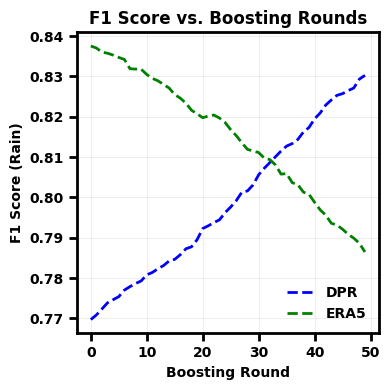

In [ ]:
plt.figure(figsize=(4, 4))

plt.plot(f1_test_dpr_rain_values, label='DPR', color='blue', linewidth=2, linestyle='--')
plt.plot(f1_era5_rain_values, label='ERA5', color='green', linewidth=2, linestyle='--')

plt.xlabel('Boosting Round', fontsize=10, fontweight='bold')
plt.ylabel('F1 Score (Rain)', fontsize=10, fontweight='bold')
plt.title('F1 Score vs. Boosting Rounds', fontsize=12, fontweight='bold')

plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight': 'bold'})
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

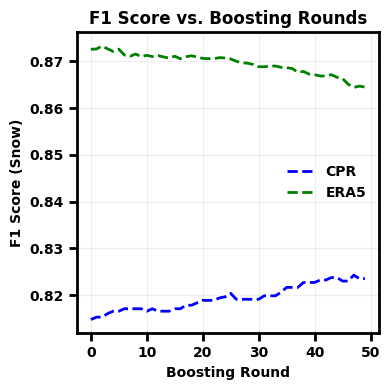

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(f1_test_cpr_snow_values, label='CPR', color='blue', linewidth=2, linestyle='--')
plt.plot(f1_era5_snow_values, label='ERA5', color='green', linewidth=2, linestyle='--')

plt.xlabel('Boosting Round', fontsize=10, fontweight='bold')
plt.ylabel('F1 Score (Snow)', fontsize=10, fontweight='bold')
plt.title('F1 Score vs. Boosting Rounds', fontsize=12, fontweight='bold')

plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight': 'bold'})

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### **2.1.2  ERA5-CPR regression base learner for snowfall retrievals**

Training the base learner for the snow rate estimation by first learning the ERA5 and then fine tuning on CloudSat snow rate

In [ ]:
X_train_snow_era5 = df_era5_snow_rate_train[input_vars]
y_train_snow_era5 = df_era5_snow_rate_train['snow_rate']

X_test_snow_era5 = df_era5_snow_rate_test[input_vars]
y_test_snow_era5 = df_era5_snow_rate_test['snow_rate']



# Convert to DMatrix format
dtrain_snow_era5 = xgb.DMatrix(X_train_snow_era5, label=y_train_snow_era5)
dtest_snow_era5 = xgb.DMatrix(X_test_snow_era5, label=y_test_snow_era5)


# Define evaluation metrics and watchlist
evals = [(dtrain_snow_era5, 'train'), (dtest_snow_era5, 'test')]

evals_result = {}

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.0392,
    'max_depth': 14,
    'reg_alpha': 4.52,
    'reg_lambda': 7.139,
    'n_estimators': 52,
    'num_parallel_tree': 6,
    'eval_metric': ['rmse']
}

# Train the model with early stopping
xgb_reg_snow_era5 = xgb.train(params, dtrain_snow_era5, num_boost_round=52, evals=evals, evals_result=evals_result, early_stopping_rounds=5)

[0]	train-rmse:0.41367	test-rmse:0.41047
[1]	train-rmse:0.39898	test-rmse:0.39584
[2]	train-rmse:0.38490	test-rmse:0.38187
[3]	train-rmse:0.37141	test-rmse:0.36844
[4]	train-rmse:0.35848	test-rmse:0.35562
[5]	train-rmse:0.34609	test-rmse:0.34334
[6]	train-rmse:0.33423	test-rmse:0.33162
[7]	train-rmse:0.32287	test-rmse:0.32038
[8]	train-rmse:0.31198	test-rmse:0.30966
[9]	train-rmse:0.30154	test-rmse:0.29937
[10]	train-rmse:0.29162	test-rmse:0.28955
[11]	train-rmse:0.28205	test-rmse:0.28020
[12]	train-rmse:0.27290	test-rmse:0.27124
[13]	train-rmse:0.26415	test-rmse:0.26273
[14]	train-rmse:0.25579	test-rmse:0.25456
[15]	train-rmse:0.24778	test-rmse:0.24674
[16]	train-rmse:0.24013	test-rmse:0.23927
[17]	train-rmse:0.23282	test-rmse:0.23218
[18]	train-rmse:0.22584	test-rmse:0.22546
[19]	train-rmse:0.21918	test-rmse:0.21901
[20]	train-rmse:0.21287	test-rmse:0.21286
[21]	train-rmse:0.20677	test-rmse:0.20707
[22]	train-rmse:0.20096	test-rmse:0.20157
[23]	train-rmse:0.19545	test-rmse:0.19630
[2

Fine tuning the model based on CPR snow rate

In [ ]:
X_train_snow_sat = df_cpr_snow_rate_train[input_vars]
y_train_snow_sat = df_cpr_snow_rate_train['snow_rate']
X_test_snow_sat = df_cpr_snow_rate_test[input_vars]
y_test_snow_sat = df_cpr_snow_rate_test['snow_rate']

dtrain_snow_rate_sat = xgb.DMatrix(X_train_snow_sat, label=y_train_snow_sat)
dtest_snow_rate_sat = xgb.DMatrix(X_test_snow_sat, label=y_test_snow_sat)

evals = [(dtest_snow_era5, 'test_era5'), (dtest_snow_rate_sat, 'test_sat'), (dtrain_snow_rate_sat, 'train_sat')]
evals_result = {}

# Set parameters for fine-tuning
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.014,
    'eval_metric': 'rmse',
    'max_depth': 15
}

# Continue training with the new data
snow_rate_booster = xgb.train(
    params,
    dtrain_snow_rate_sat,
    num_boost_round=104,
    evals=evals,
    xgb_model=xgb_reg_snow_era5,
    evals_result=evals_result,
    verbose_eval=True
)


y_pred_snow_rate_sat = snow_rate_booster.predict(dtest_snow_rate_sat)

mse_new = mean_squared_error(y_test_snow_sat, y_pred_snow_rate_sat)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.12468	test_sat-rmse:0.36871	train_sat-rmse:0.30801
[1]	test_era5-rmse:0.12464	test_sat-rmse:0.36783	train_sat-rmse:0.30674
[2]	test_era5-rmse:0.12460	test_sat-rmse:0.36699	train_sat-rmse:0.30551
[3]	test_era5-rmse:0.12461	test_sat-rmse:0.36614	train_sat-rmse:0.30429
[4]	test_era5-rmse:0.12465	test_sat-rmse:0.36529	train_sat-rmse:0.30306
[5]	test_era5-rmse:0.12467	test_sat-rmse:0.36453	train_sat-rmse:0.30189
[6]	test_era5-rmse:0.12471	test_sat-rmse:0.36380	train_sat-rmse:0.30075
[7]	test_era5-rmse:0.12476	test_sat-rmse:0.36304	train_sat-rmse:0.29963
[8]	test_era5-rmse:0.12483	test_sat-rmse:0.36231	train_sat-rmse:0.29854
[9]	test_era5-rmse:0.12490	test_sat-rmse:0.36158	train_sat-rmse:0.29745
[10]	test_era5-rmse:0.12500	test_sat-rmse:0.36089	train_sat-rmse:0.29640
[11]	test_era5-rmse:0.12510	test_sat-rmse:0.36017	train_sat-rmse:0.29528
[12]	test_era5-rmse:0.12523	test_sat-rmse:0.35951	train_sat-rmse:0.29425
[13]	test_era5-rmse:0.12536	test_sat-rmse:0.35882	train_sat-r

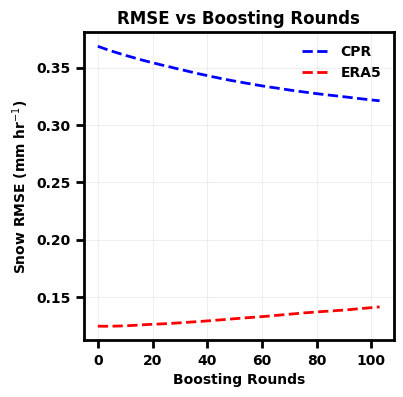

In [ ]:
# Extract RMSE values
train_rmse = evals_result['test_sat']['rmse']
test_rmse = evals_result['test_era5']['rmse']

# Plot RMSE vs Boosting rounds
plt.figure(figsize=(4, 4))
plt.plot(train_rmse, label='CPR', color='blue', linestyle='--', linewidth=2)
plt.plot(test_rmse, label='ERA5', color='red', linestyle='--', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=10, fontweight='bold')
plt.ylabel('Snow RMSE (mm hr$^{-1}$)', fontsize=10, fontweight='bold')


plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)
plt.title('RMSE vs Boosting Rounds', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight':'bold'})
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.grid(True, alpha=0.2)
plt.show()

### **2.1.5  ERA5-DPR base learner for rain retrievals**

Training the base learner for the rain rate estimation by first learning the ERA5 rain and then fine tuning on DPR datasets.

In [ ]:
# Prepare training and testing datasets
X_train_rain_era5 = df_era5_rain_rate_train[input_vars]
y_train_rain_era5 = df_era5_rain_rate_train['DPR rain Rate']

X_test_rain_era5 = df_era5_rain_rate_test[input_vars]
y_test_rain_era5 = df_era5_rain_rate_test['DPR rain Rate']

# Convert to DMatrix format
dtrain_rain_era5 = xgb.DMatrix(X_train_rain_era5, label=y_train_rain_era5)
dtest_rain_era5 = xgb.DMatrix(X_test_rain_era5, label=y_test_rain_era5)

# Define evaluation metrics and watchlist
evals = [(dtrain_rain_era5, 'train'), (dtest_rain_era5, 'test')]
evals_result = {}

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'learning_rate': 0.0392,
    'max_depth': 14,
    'reg_alpha': 4.52,
    'reg_lambda': 7.139,
    'n_estimators': 52,
    'num_parallel_tree': 6,
    'eval_metric': ['rmse']
}

# Train the model with early stopping
xgb_reg_rain_era5 = xgb.train(
    params,
    dtrain_rain_era5,
    num_boost_round=52,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=5
)

[0]	train-rmse:0.64964	test-rmse:0.69605
[1]	train-rmse:0.63445	test-rmse:0.68291
[2]	train-rmse:0.61990	test-rmse:0.67061
[3]	train-rmse:0.60602	test-rmse:0.65874
[4]	train-rmse:0.59263	test-rmse:0.64764
[5]	train-rmse:0.57995	test-rmse:0.63700
[6]	train-rmse:0.56778	test-rmse:0.62671
[7]	train-rmse:0.55604	test-rmse:0.61691
[8]	train-rmse:0.54487	test-rmse:0.60824
[9]	train-rmse:0.53424	test-rmse:0.60011
[10]	train-rmse:0.52372	test-rmse:0.59230
[11]	train-rmse:0.51372	test-rmse:0.58507
[12]	train-rmse:0.50402	test-rmse:0.57741
[13]	train-rmse:0.49482	test-rmse:0.57074
[14]	train-rmse:0.48598	test-rmse:0.56399
[15]	train-rmse:0.47742	test-rmse:0.55789
[16]	train-rmse:0.46901	test-rmse:0.55142
[17]	train-rmse:0.46112	test-rmse:0.54578
[18]	train-rmse:0.45351	test-rmse:0.54044
[19]	train-rmse:0.44608	test-rmse:0.53483
[20]	train-rmse:0.43903	test-rmse:0.52977
[21]	train-rmse:0.43235	test-rmse:0.52520
[22]	train-rmse:0.42578	test-rmse:0.52022
[23]	train-rmse:0.41950	test-rmse:0.51554
[2

In [ ]:
# Prepare training and testing datasets
X_train_rain_dpr = df_dpr_rain_rate_train[input_vars]
y_train_rain_dpr = df_dpr_rain_rate_train['DPR rain Rate']
X_test_rain_dpr = df_dpr_rain_rate_test[input_vars]
y_test_rain_dpr = df_dpr_rain_rate_test['DPR rain Rate']

# Convert to DMatrix format
dtrain_rain_rate_dpr = xgb.DMatrix(X_train_rain_dpr, label=y_train_rain_dpr)
dtest_rain_rate_dpr = xgb.DMatrix(X_test_rain_dpr, label=y_test_rain_dpr)

# Define evaluation datasets
evals = [(dtest_rain_era5, 'test_era5'), (dtest_rain_rate_dpr, 'test_dpr'), (dtrain_rain_rate_dpr, 'train_dpr')]
evals_result = {}

# Set parameters for fine-tuning
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'eval_metric': 'rmse',
    'max_depth': 15
}

# Continue training with the new data
rain_rate_booster = xgb.train(
    params,
    dtrain_rain_rate_dpr,
    num_boost_round=104,
    evals=evals,
    xgb_model=xgb_reg_rain_era5,  # pretrained model from ERA5
    evals_result=evals_result,
    verbose_eval=True
)

# Make predictions
y_pred_rain_rate_dpr = rain_rate_booster.predict(dtest_rain_rate_dpr)

# Evaluate performance
mse_new = mean_squared_error(y_test_rain_dpr, y_pred_rain_rate_dpr)
print(f"Test Mean Squared Error: {mse_new:.2f}")

[0]	test_era5-rmse:0.45740	test_dpr-rmse:2.61441	train_dpr-rmse:2.59071
[1]	test_era5-rmse:0.45804	test_dpr-rmse:2.60090	train_dpr-rmse:2.57531
[2]	test_era5-rmse:0.45881	test_dpr-rmse:2.58745	train_dpr-rmse:2.56012
[3]	test_era5-rmse:0.45964	test_dpr-rmse:2.57427	train_dpr-rmse:2.54510
[4]	test_era5-rmse:0.46044	test_dpr-rmse:2.56144	train_dpr-rmse:2.53024
[5]	test_era5-rmse:0.46137	test_dpr-rmse:2.54867	train_dpr-rmse:2.51553
[6]	test_era5-rmse:0.46234	test_dpr-rmse:2.53619	train_dpr-rmse:2.50098
[7]	test_era5-rmse:0.46350	test_dpr-rmse:2.52374	train_dpr-rmse:2.48664
[8]	test_era5-rmse:0.46456	test_dpr-rmse:2.51107	train_dpr-rmse:2.47206
[9]	test_era5-rmse:0.46568	test_dpr-rmse:2.49932	train_dpr-rmse:2.45797
[10]	test_era5-rmse:0.46694	test_dpr-rmse:2.48709	train_dpr-rmse:2.44371
[11]	test_era5-rmse:0.46826	test_dpr-rmse:2.47548	train_dpr-rmse:2.42993
[12]	test_era5-rmse:0.46968	test_dpr-rmse:2.46417	train_dpr-rmse:2.41618
[13]	test_era5-rmse:0.47114	test_dpr-rmse:2.45228	train_dpr-r

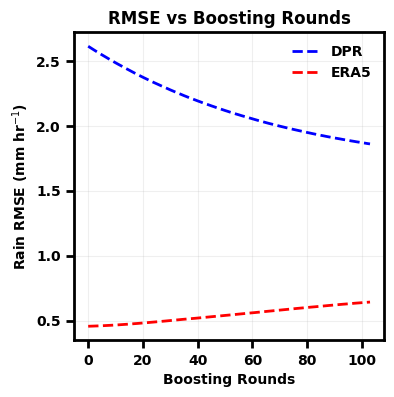

In [ ]:
# Extract RMSE values
train_rmse = evals_result['test_dpr']['rmse']
test_rmse = evals_result['test_era5']['rmse']

# Plot RMSE vs Boosting rounds
plt.figure(figsize=(4, 4))
plt.plot(train_rmse, label='DPR', color='blue', linestyle='--', linewidth=2)
plt.plot(test_rmse, label='ERA5', color='red', linestyle='--', linewidth=2)

plt.xlabel('Boosting Rounds', fontsize=10, fontweight='bold')
plt.ylabel('Rain RMSE (mm hr$^{-1}$)', fontsize=10, fontweight='bold')


plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tick_params(axis='both', which='major', length=6, width=2)
plt.title('RMSE vs Boosting Rounds', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, frameon=False, loc='best', prop={'weight':'bold'})
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
plt.grid(True, alpha=0.2)
plt.show()

# **3.  Orbial Retrievals**

In this section, the pre-trained models are loaded to retrieve rainfall and snowfall for two GMI orbits.

## **3.1) Running B-RAINS for the selected orbit**

In [ ]:
path_orbit_004780 = 'Orbit_004780/GPM_orbit_004780.npz'

# Load the .npz file
npz_004780 = np.load(path_orbit_004780)

In [ ]:
[phase, rain, snow, latitude, longitude] = TLPR2S_model(path_orbit_004780, booster, snow_rate_booster, rain_rate_booster, df_cdf_rain, df_cdf_snow);

/content/Microwave_Precipitation_Retrievals_from_TLP-R2S/Microwave_Precipitation_Retrievals_from_TLP-R2S/pmw_utils.py:269: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.05075962 0.02895142 0.05350298 ... 0.0247108  0.02431715 0.02306725]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_snowr.index, 'pred_snow_rate'] = actual_snow_values
/content/Microwave_Precipitation_Retrievals_from_TLP-R2S/Microwave_Precipitation_Retrievals_from_TLP-R2S/pmw_utils.py:279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.05068923 0.00636815 0.00662385 ... 0.01246681 0.01354579 0.01256737]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df_rainr.index, 'pred_rain_rate'] = actual_rain_values


In [ ]:
!pip install cartopy
import cartopy.crs as ccrs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


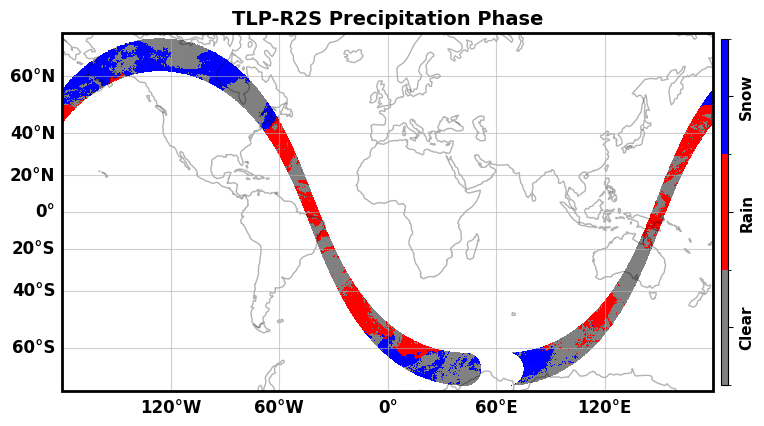

In [ ]:
cmap_custom = mcolors.ListedColormap(['grey', 'red', 'blue'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap_custom.N)

# Create figure for ERA5_flag
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111, projection=ccrs.Mercator())

mask = (longitude > 179.5) | (longitude < -179.5)
ERA5_flag_2d_masked = np.ma.masked_where(mask, phase)

# Plot using pcolormesh
plot1 = ax1.pcolormesh(longitude, latitude, ERA5_flag_2d_masked, cmap=cmap_custom, norm=norm, alpha=0.98, transform=ccrs.PlateCarree())
ax1.coastlines(alpha=0.3)

g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}


cbar1 = plt.colorbar(plot1, ax=ax1, orientation='vertical', shrink=0.75, pad=0.01, aspect=50)
cbar1.set_ticks([0.5, 1.5, 2.5])
cbar1.set_ticklabels(['Clear', 'Rain', 'Snow'])
for t in cbar1.ax.get_yticklabels():
    t.set_fontweight('bold')
    t.set_fontsize(11)
    t.set_rotation(90)
    t.set_ha('center')
    t.set_va('center')
cbar1.ax.tick_params(pad=10)
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('TLP-R2S Precipitation Phase', fontsize=14, fontweight='bold')


plt.show()

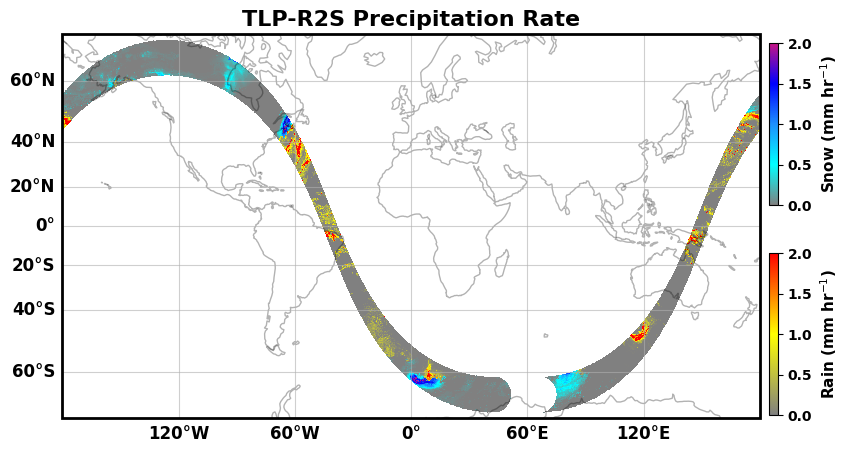

In [ ]:
# Define color maps
from matplotlib.colors import LinearSegmentedColormap
colors_snow = ['grey', 'cyan', 'dodgerblue', 'blue', 'mediumvioletred']
cmap_rate_snow = LinearSegmentedColormap.from_list("mycmap_snow", colors_snow)

colors_rain = ['grey', 'yellow', 'red']
cmap_rate_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_rain)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.Mercator()})
mask = (longitude > 179.5) | (longitude < -179.5)

snow_masked = np.ma.masked_where(mask, snow)
rain_masked = np.ma.masked_where(mask, rain)

snow_rate_masked = np.ma.masked_where(rain_masked > snow_masked, snow)
rain_rate_masked = np.ma.masked_where(snow_masked > rain_masked, rain)

# Plot snow and rain
plot1 = ax1.pcolormesh(longitude, latitude, snow_rate_masked, vmin=0, vmax=2,
                       cmap=cmap_rate_snow, transform=ccrs.PlateCarree())
plot2 = ax1.pcolormesh(longitude, latitude, rain_rate_masked, vmin=0, vmax=2,
                       cmap=cmap_rate_rain, transform=ccrs.PlateCarree())

# Coastlines and grid
ax1.coastlines(alpha=0.3)
g4 = ax1.gridlines(draw_labels=True, alpha=0.6)
g4.top_labels = False
g4.right_labels = False
g4.xlabels_bottom = True
g4.ylabels_left = True
g4.xlabel_style = {'fontsize': 12, 'fontweight': 'bold'}
g4.ylabel_style = {'fontsize': 12, 'fontweight': 'bold'}
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
ax1.set_title('TLP-R2S Precipitation Rate', fontsize=16, fontweight='bold')


cbar_ax1 = fig.add_axes([0.91, 0.53, 0.01, 0.27])
cbar_ax2 = fig.add_axes([0.91, 0.18, 0.01, 0.27])

cbar1 = fig.colorbar(plot1, cax=cbar_ax1)
cbar1.set_label('Snow (mm hr$^{-1}$)', fontsize=11, fontweight='bold')
for t in cbar1.ax.get_yticklabels():
    t.set_fontweight('bold')

cbar2 = fig.colorbar(plot2, cax=cbar_ax2)
cbar2.set_label('Rain (mm hr$^{-1}$)', fontsize=11, fontweight='bold')
for t in cbar2.ax.get_yticklabels():
    t.set_fontweight('bold')

plt.show()

/tmp/ipython-input-2878991394.py:109: RuntimeWarning: divide by zero encountered in log2
  im7 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(rain_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-2878991394.py:112: RuntimeWarning: divide by zero encountered in log2
  im7_1 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(snow_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-2878991394.py:122: RuntimeWarning: divide by zero encountered in log2
  im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-2878991394.py:122: RuntimeWarning: invalid value encountered in log2
  im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
/tmp/ipython-input-2878991394.py:126: RuntimeWarning: divide by

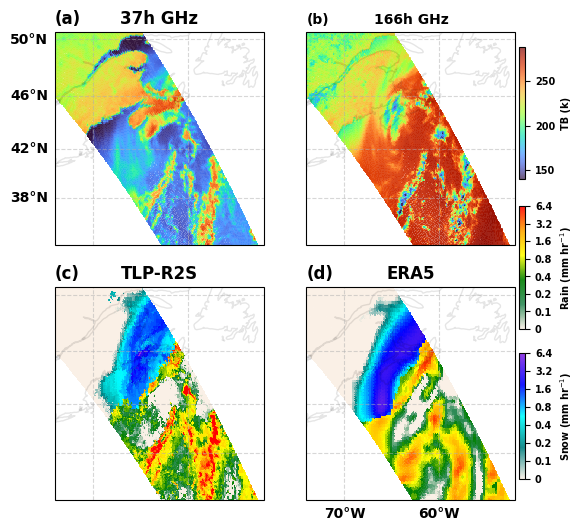

In [ ]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from matplotlib.colors import PowerNorm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, LogNorm
from matplotlib.ticker import LogLocator, FuncFormatter
import warnings
#import colorcet as cc

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy.mpl.gridliner")


#colors_1 = ['grey', 'lawngreen', 'gold', 'darkorange']
colors_1 = ['linen', 'seagreen' ,'green', 'yellow', 'orange', 'red']



rate_colors = ['linen', 'teal', 'cyan', 'blue', 'blueviolet']  # For snow_rate plots

rate_bt = ['lightblue', 'teal','cyan', 'green', 'yellowgreen','yellow', 'red']

# Create colormap objects
cmap_rain = LinearSegmentedColormap.from_list("mycmap_rain", colors_1, N=256)
cmap_snow = LinearSegmentedColormap.from_list("mycmap_snow", rate_colors)
cmap_bt = LinearSegmentedColormap.from_list("mycmap_snow", rate_bt)


new_cmap = cmap_rain
my_cmap = cmap_snow


# Mask data based on lon_2d values
mask = (longitude > -52) | (longitude < -74)

snow_rate_masked = np.ma.masked_where(rain_masked > snow_masked, snow)
rain_rate_masked = np.ma.masked_where(snow_masked > rain_masked, rain)

snow_pred_2d = np.ma.masked_where(mask, snow)
rain_pred_2d = np.ma.masked_where(mask, rain)
snow_rate_masked = np.ma.masked_where(rain_pred_2d > snow_pred_2d, snow)
rain_rate_masked = np.ma.masked_where(snow_pred_2d > rain_pred_2d, rain)


snow_era5 = npz_004780['snow_era5']
rain_era5= npz_004780['rain_era5']
snow_era5_2d = np.ma.masked_where(mask, snow_era5)
rain_era5_2d = np.ma.masked_where(mask, rain_era5)

snow_rate_era5_masked = np.ma.masked_where(rain_era5_2d > snow_era5_2d, snow_era5)
rain_rate_era5_masked = np.ma.masked_where(snow_era5_2d > rain_era5_2d, rain_era5)



tb_37h= npz_004780['36h']
tb_166h= npz_004780['166h']
tb_37h_2d = np.ma.masked_where(mask, tb_37h)
tb_166h_2d = np.ma.masked_where(mask, tb_166h)
# Plotting
fig, axes = plt.subplots(
    2, 2, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()},
    gridspec_kw={'height_ratios': [1, 1], 'left': 0.05, 'bottom': 0.2,
                 'right': 0.85, 'top': 0.98, 'hspace': 0.2, 'wspace': 0.1})

import matplotlib.ticker as mticker  # Ensure mticker is imported

# Helper function to configure gridlines with custom intervals
def configure_gridlines(ax, x_bottom=True, y_left=True, lat_interval=10, lon_interval=10):
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = y_left
    gl.bottom_labels = x_bottom

    # Set custom intervals for latitude and longitude labels
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, lon_interval))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, lat_interval))
    ax.set_xticks(np.arange(-180, 181, lon_interval))
    ax.set_yticks(np.arange(-90, 91, lat_interval))


    gl.xlabel_style = {'fontsize': 10, 'fontweight': 'bold'}
    gl.ylabel_style = {'fontsize': 10, 'fontweight': 'bold'}



# Plot 1: 37h
im1 = axes[0, 0].pcolormesh(longitude, latitude, tb_37h_2d,  vmin=140, vmax=288,
                            cmap= 'turbo', alpha=0.7, transform=ccrs.PlateCarree())
axes[0, 0].coastlines(alpha=0.1)
configure_gridlines(axes[0, 0], lat_interval=4, lon_interval=10, y_left=True, x_bottom=False)
axes[0, 0].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[0, 0].set_title('37h GHz', fontsize=12, fontweight='bold')
axes[0, 0].set_title('(a)', fontsize=12, fontweight='bold', loc='left')

# Plot 4: 166h
im3 = axes[0, 1].pcolormesh(longitude, latitude, tb_166h_2d, vmin=140, vmax=288,
                            cmap= 'turbo', alpha=0.7, transform=ccrs.PlateCarree())
axes[0, 1].coastlines(alpha=0.1)
configure_gridlines(axes[0, 1], lat_interval=4, lon_interval=10, y_left=False, x_bottom=False)
axes[0, 1].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[0, 1].set_title('166h GHz', fontsize=10, fontweight='bold')
axes[0, 1].set_title('(b)', fontsize=10, fontweight='bold', loc='left')

# Plot 6: Rain and snow from B-RAIN
im7 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(rain_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=new_cmap, alpha=0.9, transform=ccrs.PlateCarree())
snow_pred_2d = np.where(snow_pred_2d < rain_pred_2d, np.nan, snow_pred_2d)
im7_1 = axes[1, 0].pcolormesh(longitude, latitude, np.log2(snow_rate_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=cmap_snow, alpha=0.9, transform=ccrs.PlateCarree())
axes[1, 0].coastlines(alpha=0.1)
configure_gridlines(axes[1, 0], lat_interval=4 , lon_interval=10, y_left=False, x_bottom=False)
axes[1, 0].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[1, 0].set_title('TLP-R2S', fontsize=12, fontweight='bold')
axes[1, 0].set_title('(c)', fontsize=12, fontweight='bold', loc='left')


# Plot 5: Rain and snow from ERA5
im4 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(rain_rate_era5_masked+ 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=new_cmap, alpha=0.9, transform=ccrs.PlateCarree())
snow_era5_2d = np.where(snow_era5_2d < rain_era5_2d, np.nan, snow_era5_2d)

im4_1 = axes[1, 1].pcolormesh(longitude, latitude, np.log2(snow_rate_era5_masked + 1e-10), norm = Normalize(vmin=np.log2(0.05), vmax=np.log2(6.4)),
                            cmap=cmap_snow, alpha=0.9, transform=ccrs.PlateCarree())
axes[1, 1].coastlines(alpha=0.1)
configure_gridlines(axes[1, 1], lat_interval=4, lon_interval=10, y_left=False, x_bottom=True)
axes[1, 1].set_extent([-74, -52, 34, 50.5], ccrs.PlateCarree())
axes[1, 1].set_title('ERA5', fontsize=12, fontweight='bold')
axes[1, 1].set_title('(d)', fontsize=12, fontweight='bold', loc='left')

from matplotlib import ticker

# Upper row colorbar (Snow Rate)
cbar_ax1 = fig.add_axes([0.84, 0.735, 0.01, 0.22])  # Position for the upper row colorbar
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cbar1.set_label('TB (k)', fontsize=7, fontweight='bold')

# Set tick label properties
for tick in cbar1.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')

############################################################################################################
cbar_ax2 = fig.add_axes([0.84, 0.485, 0.01, 0.205])
cbar2 = fig.colorbar(im4, cax=cbar_ax2, orientation='vertical', label='Rain Rate (mm hr$^{{-1}}$)')
rain_ticks = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
log_ticks = np.log2(np.clip(rain_ticks, 1e-10, None))

cbar2.set_ticks(log_ticks)

tick_labels = ['0' if tick == 0.05 else f"{tick:.1f}" for tick in rain_ticks]
cbar2.set_ticklabels([f"{tick}" for tick in tick_labels])

# Set tick label properties
for tick in cbar2.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')


cbar2.set_label('Rain (mm hr$^{-1}$)', fontsize=7, fontweight='bold')
###########################################################################################
cbar_ax3 = fig.add_axes([0.84, 0.235, 0.01, 0.21])
cbar3 = fig.colorbar(im7_1, cax=cbar_ax3, orientation='vertical')
snow_ticks = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
log_ticks = np.log2(np.clip(snow_ticks, 1e-10, None))

cbar3.set_ticks(log_ticks)

tick_labels = ['0' if tick == 0.05 else f"{tick:.1f}" for tick in snow_ticks]
cbar3.set_ticklabels([f"{tick}" for tick in tick_labels])

# Set tick label properties
for tick in cbar3.ax.get_yticklabels():
    tick.set_fontsize(7)
    tick.set_fontweight('bold')


cbar3.set_label('Snow (mm hr$^{-1}$)', fontsize=7, fontweight='bold')


plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()